In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn import svm
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV

When importing dataset, by sorting with MatchID, dataset is now timeseries dataset. Every feature is (home-away) and result is decided with score diff. We have total 50 feature differences.

In [2]:
data=pd.read_csv('Data/Dataset.csv').drop(['Unnamed: 0'],axis=1).sort_values(by=['MatchID'])
df_home=data.filter(regex='home').rename(columns=lambda x:x.replace('_home',''))
df_away=data.filter(regex='away').rename(columns=lambda x:x.replace('_away',''))
df_diff=df_home-df_away
cond=[(df_diff['Score']<0),(df_diff['Score']==0),(df_diff['Score']>0)]
val=['Away','Draw','Home']
df_diff['Result']=np.select(cond,val)
df_diff=df_diff.drop(columns=['Score'])
X=df_diff.iloc[:,:-1]
y=df_diff.iloc[:,-1:].values.ravel()

In [3]:
scaler = StandardScaler().fit(X)
X_scaled = scaler.transform(X)

## Feature selection

Feature ranking:
1. feature Clean sheets (0.041)
2. feature Goals (0.035)
3. feature Assists (0.034)
4. feature Big Chances Created (0.031)
5. feature Passes (0.031)
6. feature Blocked shots (0.029)
7. feature Goals Conceded (0.024)
8. feature Shots on target (0.021)
9. feature Hit woodwork (0.021)
10. feature Shots (0.021)
11. feature Goals with right foot (0.021)
12. feature Tackle success % (0.020)
13. feature Crosses (0.020)
14. feature Big chances missed (0.020)
15. feature Goals with left foot (0.019)
16. feature Own goals (0.019)
17. feature Cross accuracy % (0.019)
18. feature Penalties scored (0.019)
19. feature Shooting accuracy % (0.019)
20. feature Last man tackles (0.019)
21. feature Clearances off line (0.019)
22. feature Accurate long balls (0.019)
23. feature Errors leading to goal (0.018)
24. feature Catches (0.018)
25. feature Throw outs (0.018)
26. feature Through balls (0.018)
27. feature Sweeper clearances (0.018)
28. feature Punches (0.018)
29. feature Goals per m

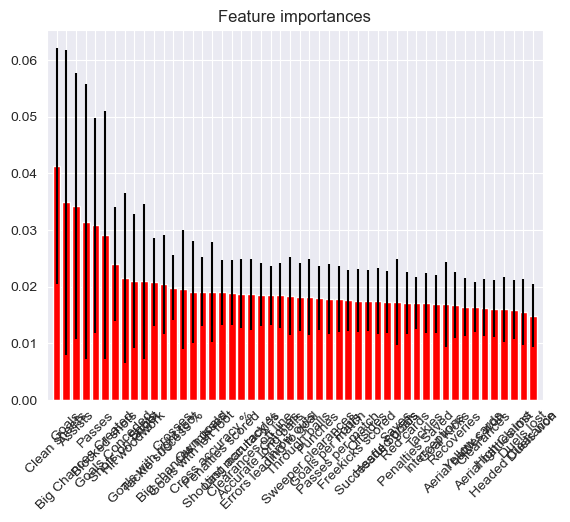

In [5]:
forest=RandomForestClassifier()
forest.fit(X,y)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("{}. feature {} ({:.3f})".format(f + 1, X.columns[indices][f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), X.columns[indices], rotation=45)
plt.xlim([-1, X.shape[1]])
plt.show()

In [6]:
X=X.drop(columns=X.columns[indices[15:]])

## Train,Test,Validation set split
Split train,test,validation set into 0.8,0.1,0.1

In [7]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2)
X_test,X_val,y_test,y_val=train_test_split(X_test,y_test,test_size=0.5)

In [8]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape, X_val.shape, y_val.shape

((2835, 15), (2835,), (354, 15), (354,), (355, 15), (355,))

## Logistic Regression

In [58]:
clf = LogisticRegression()
clf.max_iter=500
clf.fit(X_train, y_train)

LogisticRegression(max_iter=500)

In [59]:
clf.score(X_test,y_test)

0.5508474576271186

In [60]:
clf.score(X_val,y_val)

0.5464788732394367

## SVM

In [61]:
clf = svm.SVC()
clf.fit(X_train,y_train)

SVC()

In [62]:
clf.score(X_test,y_test)

0.5480225988700564

In [63]:
clf.score(X_val,y_val)

0.5183098591549296

## SVM pairwise

In [64]:
clf=svm.LinearSVC()
clf.fit(X_train,y_train)

/Users/hokuma/miniconda/lib/python3.9/site-packages/sklearn/svm/_base.py:1225: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


LinearSVC()

In [65]:
clf.score(X_test,y_test)

0.5508474576271186

In [66]:
clf.score(X_val,y_val)

0.5408450704225352

## GridSearch to optimize hyperparameter

In [67]:
parameters = {'kernel':('linear', 'rbf'), 'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 'C':[1, 10]}
svc=svm.SVC()
clf = GridSearchCV(svc, parameters)
clf.fit(X_train,y_train)

GridSearchCV(estimator=SVC(),
             param_grid={'C': [1, 10], 'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ('linear', 'rbf')})

In [68]:
print(clf.best_params_)

{'C': 1, 'gamma': 1, 'kernel': 'linear'}


In [9]:
clf=svm.SVC(C=1,gamma=1,kernel='linear')
clf.fit(X_train,y_train)

SVC(C=1, gamma=1, kernel='linear')

In [10]:
clf.score(X_test,y_test)

0.5338983050847458

In [11]:
clf.score(X_val,y_val)

0.5605633802816902

In [12]:
clf = svm.SVC(C=5, gamma=1, kernel='linear')
clf.fit(X_train, y_train)

SVC(C=5, gamma=1, kernel='linear')

In [41]:
clf.score(X_test,y_test)

0.5621468926553672

In [42]:
clf.score(X_val,y_val)

0.5295774647887324

In [43]:
clf=svm.SVC(C=10,gamma=1,kernel='rbf')
clf.fit(X_train,y_train)

SVC(C=10, gamma=1)

In [44]:
clf.score(X_test,y_test)

0.5310734463276836

In [45]:
clf=svm.SVC(C=5,gamma=1,kernel='rbf')
clf.fit(X_train,y_train)

SVC(C=5, gamma=1)

In [46]:
clf.score(X_test,y_test)

0.53954802259887